In [99]:
# Autoreload external modules https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from path_provider import PathProvider
from ellipse_detector import EllipseDetector
cv.useOptimized()

True

In [101]:
def examine_imgs(procces_img_func, data, columns = 4, size = 10, show_title=True):
    """
    data - image/image_path depends on procces_img_func
    procces_img_func - funcion, that take exactly one argument -> image/image_path and return processed image
    """
    rows = len(data) / columns + 1
    figsize = (size*columns, size*rows)
    f = plt.figure(figsize=figsize)
    for i, image in enumerate(data):
        img = procces_img_func(image)
        sp = f.add_subplot(rows, columns, i+1)
        sp.axis('Off')
        if show_title:
            title_text = str(i)
            # if items in data are type of string
            if isinstance(image, str):
                title_text += image
            sp.set_title(title_text, fontsize=18)
        plt.imshow(img)
    plt.show() 
    
    
def grey2RGB(image):
    return cv.cvtColor(image,cv.COLOR_GRAY2RGB)

def identity(image):
    return image

def image_equalization_to8bit(image):
    return (cv.normalize(image, dst=None, alpha=0, beta=65535, norm_type=cv.NORM_MINMAX)/256).astype('uint8')

In [102]:
path_provider = PathProvider()
img_paths_dict = path_provider.get_paths_dict()
img_paths = path_provider.get_paths_list()

In [103]:
original_img = cv.imread(img_paths[0], cv.IMREAD_ANYDEPTH)  # choose image
img = image_equalization_to8bit(original_img)

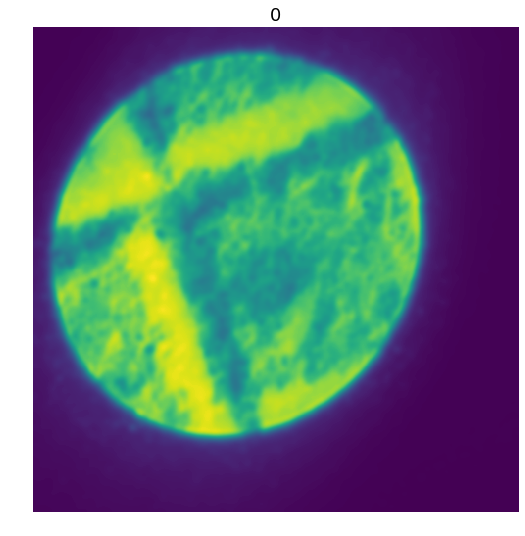

In [104]:
img = cv.GaussianBlur(img, (13, 13), sigmaX=0, sigmaY=0)
img = cv.GaussianBlur(img, (31, 31), sigmaX=0, sigmaY=0)  # 2 times for better blur of peaks
examine_imgs(identity, [img])

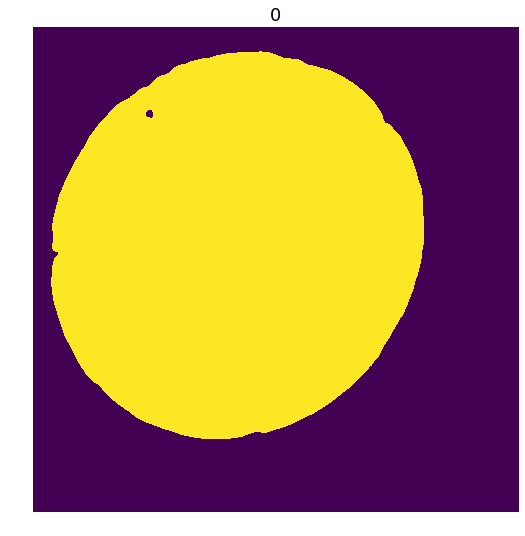

In [105]:
_, img = cv.threshold(img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
examine_imgs(identity, [img])

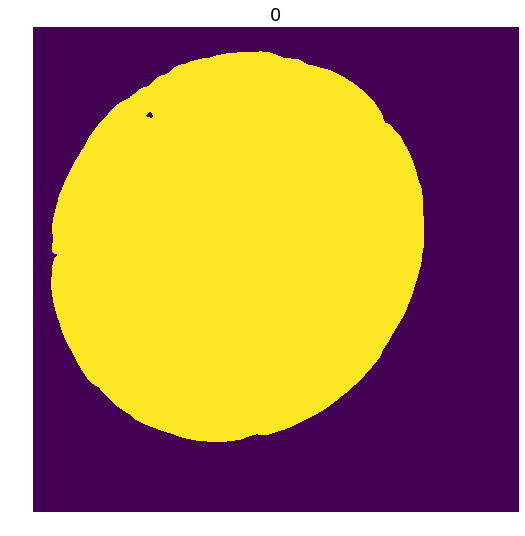

In [106]:
img = cv.dilate(img, (5, 5), iterations=5)
examine_imgs(identity, [img])

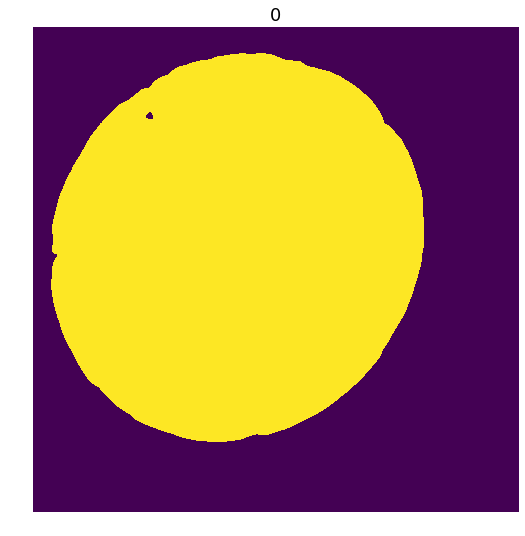

In [107]:
img = cv.erode(img, (5, 5), iterations=3)
examine_imgs(identity, [img])

### Draw all detected ellipses

In [108]:
def processing_f1(img):
    # blur_img = cv.medianBlur(img,5)
    blur_img = cv.GaussianBlur(img,(5,5),0)
    _, th = cv.threshold(blur_img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    kernel = np.ones((5,5),np.uint8)
    dilation = cv.dilate(th,kernel,iterations = 12)
    erosion = cv.erode(dilation,kernel,iterations = 5)
    return erosion

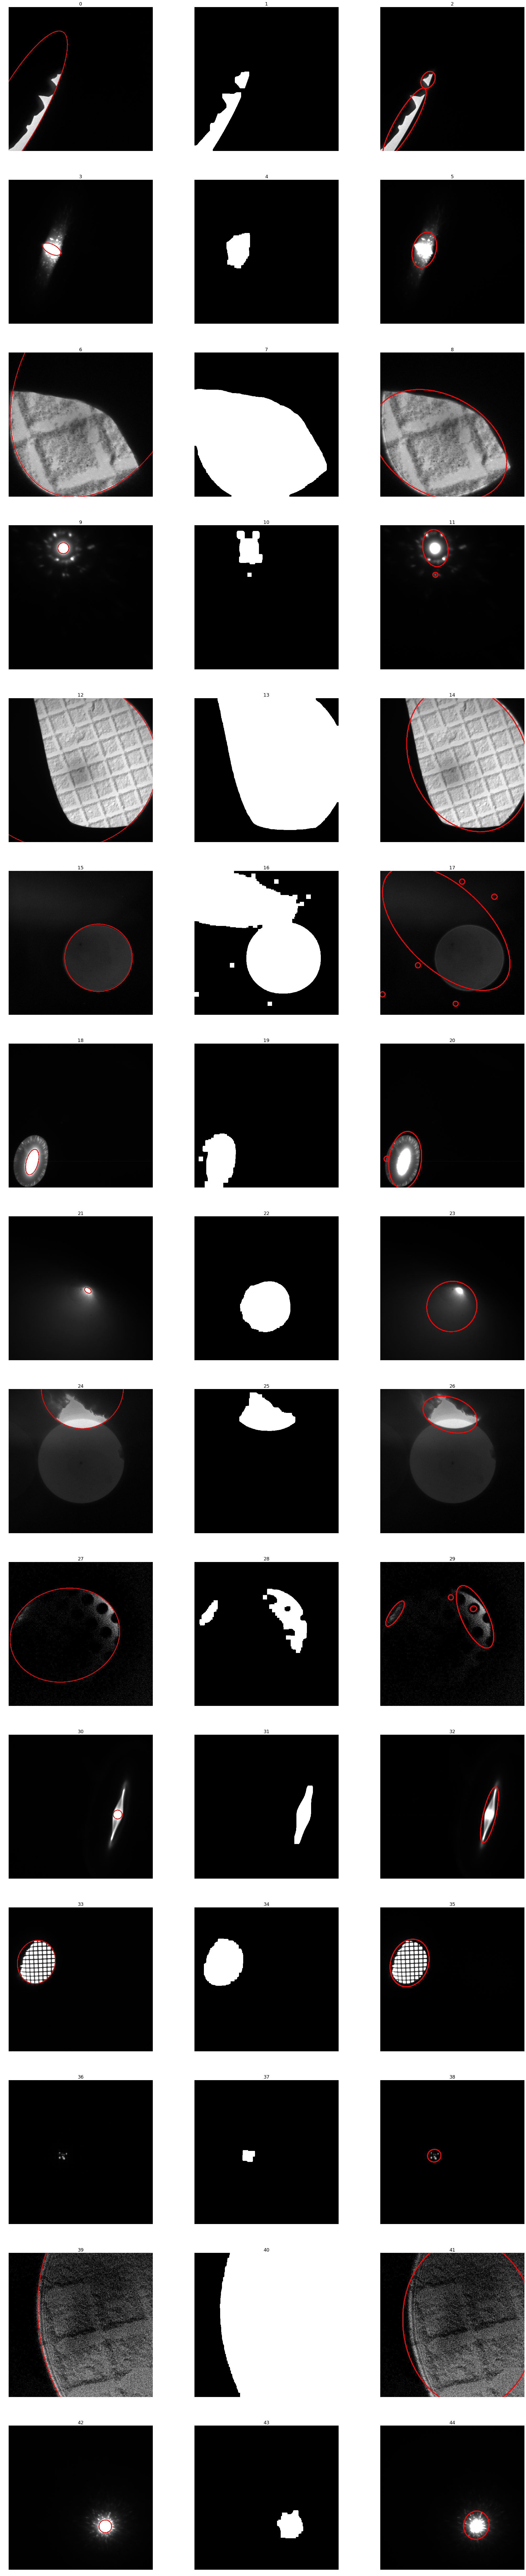

In [110]:
# preprocessing_f1 function with exacly one parametr: input image and return processed image 
processing_func = processing_f1
ellipse_detector = EllipseDetector()

NUM_TO_PLOT = 100
CATEGORY = 6
columns = 3
size_of_img = 12

img_analysis = []
img_paths_to_plot = img_paths_dict[CATEGORY]
for img_path in img_paths_to_plot[:NUM_TO_PLOT]:   
    # ground truth 
    ground_truth_path = path_provider.get_ground_truth_path(img_path)
    ground_truth_img = cv.imread((ground_truth_path))
    img_analysis.append(cv.cvtColor(ground_truth_img,cv.COLOR_BGR2RGB))

    # equalized image
    raw = cv.imread((img_path), cv.IMREAD_ANYDEPTH)
    raw_normalized = image_equalization_to8bit(raw)
    input_to_ellipse_matcher = processing_func(raw_normalized)
    img_analysis.append(cv.cvtColor(input_to_ellipse_matcher, cv.COLOR_GRAY2RGB))
    
    # raw with elipse
    #ellipse = ellipse_detector.detect(input_to_ellipse_matcher)
    #img_rgb = cv.cvtColor(raw_normalized, cv.COLOR_GRAY2RGB)
    #img_with_ellipse = cv.ellipse(img_rgb, ellipse, (255, 0, 0), thickness=5)
    #img_analysis.append(img_with_ellipse)
    
    # raw with all elipses
    ellipses = ellipse_detector.detect_all_ellipses(input_to_ellipse_matcher)
    img_rgb = cv.cvtColor(raw_normalized, cv.COLOR_GRAY2RGB)
    img_with_ellipse = img_rgb.copy()
    for el in ellipses:
        img_with_ellipse = cv.ellipse(img_with_ellipse, el, (255, 0, 0), thickness=5)

    img_analysis.append(img_with_ellipse)


examine_imgs(identity, img_analysis, 3, 12)